In [1]:
from skimage.io.collection import ImageCollection
from skimage.io import imread
from skimage.color import rgb2gray
from joblib import Parallel,delayed
from typing import Tuple, List
from tqdm import tqdm
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import ml_metrics as metrics
import cv2
import pickle
import os
import multiprocessing

In [2]:
# Choosing Number of Cores to use for multiprocessing
n_process = multiprocessing.cpu_count()

if n_process > 1 and n_process < 4:
    n_process = 2
elif n_process >= 4:
    n_process = 4
else:
    n_process = 1

In [3]:
"""
   Load images from DataBase and QuerySets
"""
def load_data() -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    # We use ImageCollection to load all images inside folders
    db = ImageCollection("../data/BBDD/*.jpg")
    print('BBDD read: {} images'.format(len(db)))
    qs1 = ImageCollection("../data/qsd1_w1/*.jpg")
    print('QuerySet1 read: {} images'.format(len(qs1)))
    qs2 = ImageCollection("../data/qsd2_w1/*.jpg")
    print('QuerySet2 read: {} images'.format(len(qs2)))
    
    return db, qs1, qs2

In [4]:
"""
   Computes image's histograms for each color channel (r,g,b) and concatenates them
   to create a feature vector
"""
def get_histogram_vector(image: np.ndarray,n_bins: int = 16) -> np.ndarray:
   # Histogram calculation per Red, Green, Blue and Gray Channel using n_bins
   r_hist = np.histogram(image[:, :, 0],bins=n_bins)[0]
   g_hist = np.histogram(image[:, :, 1],bins=n_bins)[0]
   b_hist = np.histogram(image[:, :, 2],bins=n_bins)[0]
   gray_hist = np.histogram(rgb2gray(image),bins=n_bins)[0]
   
   # Normalize histograms
   r_hist = ((r_hist - np.min(r_hist)) / (np.max(r_hist) - np.min(r_hist))).astype(np.float32)
   g_hist = ((g_hist - np.min(g_hist)) / (np.max(g_hist) - np.min(g_hist))).astype(np.float32)
   b_hist = ((b_hist - np.min(b_hist)) / (np.max(b_hist) - np.min(b_hist))).astype(np.float32)
   gray_hist = ((gray_hist - np.min(gray_hist)) / (np.max(gray_hist) - np.min(gray_hist))).astype(np.float32)
   
   # Join all Histograms into a single feature vector
   feature_vector = np.hstack((r_hist,g_hist,b_hist,gray_hist))
   
   return feature_vector


"""
   Computes feature vector for each image of our dataset.
"""    
def get_feature_matrix(dataset: np.ndarray, desc: str, n_bins: int = 16) -> np.ndarray:
   # Build feature matrix applying get_histogram_vector over all images in dataset
   # We apply some multiprocessing so we can reduce processing time by half
   feature_matrix = Parallel(n_jobs=n_process)(delayed(get_histogram_vector)(image,n_bins)for image in tqdm(dataset,desc=desc))
   return np.array(feature_matrix)  

In [5]:
"""
   Computes cos similarity between feature vector and all BBDD feature vectors
"""    
def cos_similarity(vector: np.ndarray) -> np.ndarray:
   # We take profit of numpy broadcasting to calculate cos similarity between the provided vector and all BBDD features
   return db_feature_matrix.dot(vector)/ (np.linalg.norm(db_feature_matrix, axis=1) * np.linalg.norm(vector))


"""
   Computes euclidean similarity between feature vector and all BBDD feature vectors
"""   
def euclidean_similarity(vector: np.ndarray) -> np.ndarray:
   # We take profit of numpy broadcasting to calculate euclidean similarity between the vector and all BBDD features
   dist = (db_feature_matrix - vector)**2
   dist = np.sum(dist, axis=1)
   dist = np.sqrt(dist)
   dist = np.max(dist) - dist
   return dist


"""
   Computes histogram intersection for each channel between 2 feature vectors
"""
def compute_histogram_intersect_vector(vector1: np.ndarray, vector2: np.ndarray) -> np.ndarray:
   # Recover each channel and Calculate intersection
   n_bins = int(len(vector1)/4)
   r = np.sum(np.minimum(vector1[:n_bins], vector2[:n_bins]))
   g = np.sum(np.minimum(vector1[n_bins:2*n_bins], vector2[n_bins:2*n_bins]))
   b = np.sum(np.minimum(vector1[2*n_bins:3*n_bins], vector2[2*n_bins:3*n_bins]))
   gray = np.sum(np.minimum(vector1[3*n_bins:], vector2[3*n_bins:]))
   # Retrieve mean
   return np.mean([r,g,b,gray])


"""
   Computes histogram intersection for each channel between 2 feature vectors
"""
def histogram_similarity(vector1: np.ndarray) -> np.ndarray:
   return np.array([compute_histogram_intersect_vector(vector1,vector2) for vector2 in db_feature_matrix])


def compute_histogram_correlation_vector(vector1: np.ndarray, vector2: np.ndarray) -> np.ndarray:
   n_bins = int(len(vector1)/4)
   r = cv2.compareHist(vector1[:n_bins], vector2[:n_bins],cv2.HISTCMP_CORREL)
   g = cv2.compareHist(vector1[n_bins:2*n_bins], vector2[n_bins:2*n_bins],cv2.HISTCMP_CORREL)
   b = cv2.compareHist(vector1[2*n_bins:3*n_bins], vector2[2*n_bins:3*n_bins],cv2.HISTCMP_CORREL)
   gray = cv2.compareHist(vector1[3*n_bins:], vector2[3*n_bins:],cv2.HISTCMP_CORREL)
   return np.mean([r,g,b,gray])


"""
   Computes histogram correlation bewteen vector and BBDD feature vectors
"""
def correlation_similarity(vector1: np.ndarray) -> np.ndarray:
   return np.array([compute_histogram_correlation_vector(vector1,vector2) for vector2 in db_feature_matrix])


"""
   Computes similairty for an entire QuerySet
"""    
def compute_similarities(qs: np.ndarray,desc: str, similarity: str = 'cos') -> np.ndarray:
   # Perform similarity for each vector in the QuerySet
   if similarity == "cos":
      return np.array([cos_similarity(vector) for vector in tqdm(qs,desc=desc)])
   
   elif similarity == "intersection":
      return np.array([histogram_similarity(vector1=vector) for vector in tqdm(qs,desc=desc)])
   
   elif similarity == "euclidean":
      return np.array([euclidean_similarity(vector) for vector in tqdm(qs,desc=desc)])
   
   elif similarity == "correlation":
      return np.array([correlation_similarity(vector) for vector in tqdm(qs,desc=desc)])
   
   elif similarity == "mixed":
      return np.array([correlation_similarity(vector)+cos_similarity(vector) for vector in tqdm(qs,desc=desc)])
      

In [6]:
"""
   Retrieves the top k similar images for a vector.
"""    
def get_top_k_vector(similarity_vector: np.ndarray, k: int) -> List[str]:
   # We get top K index of the vector (unordered)
   idx = np.argpartition(similarity_vector, -k)[-k:]
   
   # Then we order index in order to get the ordered top k values
   top_k = list(similarity_vector[idx])
   sorted_top = list(sorted(top_k,reverse=True))
   idx = [idx[top_k.index(i)] for i in sorted_top]
   
   # ImageCollection also saves in .files so we can easily retrieve them
   return [db.files[i] for i in idx]


"""
   Retrieves the top k similar images for a QuerySEt
"""    
def get_top_k(similarity_matrix: np.ndarray, k: int, desc: str) -> List[List[str]]:
   # Estimate top k values for all the Queryet
   return [get_top_k_vector(vector,k) for vector in tqdm(similarity_matrix, desc = desc)]


"""
   Retrieves the top k similar images for a vector.
"""    
def get_bot_k_vector(similarity_vector: np.ndarray, k: int) -> List[str]:
   # We get bot K index of the vector (unordered)
   idx = similarity_vector.argsort()[:k]
   
   # Then we order index in order to get the ordered bot k values
   bot_k = list(similarity_vector[idx])
   sorted_bot = list(sorted(bot_k,reverse=False))
   idx = [idx[bot_k.index(i)] for i in sorted_bot]
   
   # ImageCollection also saves in .files so we can easily retrieve them
   return [db.files[i] for i in idx]


"""
   Retrieves the bot k similar images for a QuerySet.
"""    
def get_bot_k(similarity_matrix: np.ndarray, k: int, desc: str) -> List[List[str]]:
   # Estimate bot k values for all the Queryet
   return [get_bot_k_vector(vector,k) for vector in tqdm(similarity_matrix, desc = desc)]
 
 

In [7]:
"""
    Image path to ID
"""
def get_image_id(image: str) -> str:
    # Extract BBBD_XXX.jpg from relative path
    file = image.split("/")[3]
    # Extract XXX id from BBBD_XXX.jpg 
    id = file.replace(".jpg","").split("_")[1]
    return int(id)


"""
    Save Results properly formated
"""
def save_results(results: List[List[str]], path: str) -> None:
    # Vectorize function to apply to each element in results
    get_ids = np.vectorize(get_image_id)
    results = get_ids(results)
    
    # Creates Save Folder 
    if not os.path.exists(path):
        os.makedirs(path)
    
    # Saves data
    pickle.dump(obj = results,file = open(path+"/result.pkl","wb"))
    print("Results Saved!")
    return results


"""
   Plot 1st Query Results
"""   
def plot_image_and_similar() -> None:
    
    for i in range(30):
        f, axarr = plt.subplots(1,2, figsize=(10,10))
        base = qs1[i]
        query = imread(top_k_qs1[i][0])
        axarr[0].imshow(base)
        axarr[0].title.set_text("Base")
        axarr[1].imshow(query)
        axarr[1].title.set_text("Query")
        plt.show()

# QUERYSET 1 

In [ ]:
# Load Data
db, qs1, qs2 = load_data()

# Feature extraction
db_feature_matrix = get_feature_matrix(dataset = db, n_bins = 16, desc = "Creating feature matrix for BBDD...(n_process = {})".format(n_process))
qs1_feature_matrix = get_feature_matrix(dataset = qs1, n_bins = 16, desc = "Creating feature matrix for QuerySet1...(n_process = {})".format(n_process))

# Similarity Computation
qs1_similarities = compute_similarities(qs = qs1_feature_matrix, desc = "Computing qs1 similarities...", similarity = 'correlation')

# Top K Estimation
top_k_qs1 = get_top_k(qs1_similarities, k = 1, desc = "Retrieving qs1 top K similar images...")

# Evaluation and Saving
predicted_results = save_results(top_k_qs1,"./week1/QST1/method1")
expected_results = pickle.load(open('../data/qsd1_w1/gt_corresps.pkl', "rb"))
metric = metrics.mapk(actual=expected_results,predicted=predicted_results,k=1)
print("MAP@K Score: {:.4f}% ({}/{})".format(metric*100,int(len(predicted_results)*metric),len(predicted_results)))


In [ ]:
plot_image_and_similar()

# Queryset 2

Based on [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) a thresholding color method.
The algorithm exhaustively searches for the threshold that minimizes the intra-class variance, defined as a weighted sum of variances of the two classes:

<img src="https://miro.medium.com/max/1400/1*GQNVs_s3g9QshW3uco7dvA.png"
     alt="https://miro.medium.com/max/1400/1*GQNVs_s3g9QshW3uco7dvA.png"
     style="float: left; margin-right: 10px;max-height:600px; max-width:600px" />


In [13]:
def otsus_binarization(gray_image: np.ndarray) -> float:

    # Histogram
    hist, bin_edges = np.histogram(gray_image, bins=256)

    # Medium from bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

    # Get the probabilities w1(t), w2(t) with the accumulative probability/distribution of intensities
    w1 = np.cumsum(hist)
    w2 = np.cumsum(hist[::-1])[::-1]

    # Class 1 Mean
    sigma1 = np.cumsum(hist * bin_mids) / w1
    
    # Class 2 Mean
    sigma2 = (np.cumsum((hist * bin_mids)[::-1]) / w2[::-1])[::-1]

    # Variances
    variance_between_classes = w1[:-1] * w2[1:] * (sigma1[:-1] - sigma2[1:]) ** 2

    # Maximize the inter_class_variance function val aka the threshold
    idx_max_variance = np.argmax(variance_between_classes)
    th = bin_mids[:-1][idx_max_variance]
    
    print("Threshold found: {} ({} if not normalized)".format(th,th*255))
    
    # Generate Mask
    gray_image[gray_image >= th] = 1
    gray_image[gray_image <= th] = 0
    
    
    return gray_image


def crop_image(mask: np.ndarray) -> List[List[int]]:
    mid_i, mid_j = int(mask.shape[0]/2),int(mask.shape[1]/2)
    offset = 50
    
    mid_row = mask[mid_i,:]
    mid_col = mask[:,mid_j]
    
    left = np.where(mid_row == 0)[0][0]
    right = np.where(mid_row == 0)[0][-1]
    top = np.where(mid_col == 0)[0][0]
    bot = np.where(mid_col == 0)[0][-1]
    
    new_mask = np.zeros_like(mask)
    new_mask[top:bot,left:right] = 1
    
    return new_mask, (top,bot,left,right)


def crop_image_2(mask: np.ndarray) -> List[List[int]]:
    # Mid Column and Mid Row
    mid_i, mid_j = int(mask.shape[0]/2),int(mask.shape[1]/2)
    mid_row = mask[mid_i,:]
    mid_col = mask[:,mid_j]
    # Offset to initial points
    offset = 50
    th = 0.15
    
    top = None
    bot = None
    left = None
    right = None
    
    # Search left boundary
    found = False
    i = offset
    

    while not found:
        if abs(mid_row[i] - mid_row[i-1]) >= th: 
            found = True
            left = i
        i += 1


    # Search right boundary
    found = False
    i = mid_row.shape[0] - 1
    while not found:
        if abs(mid_row[i] - mid_row[i-1]) >= th:
            found = True
            right = i
        i -= 1


    # Search top boundary
    found = False
    j = 0
    while not found:
        if abs(mid_col[j] - mid_col[j-1]) >= th:
            found = True
            top = j
        j += 1

    # Search bot boundary
    found = False
    j = mid_col.shape[0] - 1
    while not found:
        if abs(mid_col[j] - mid_col[j-1]) >= th:
            found = True
            bot = j
        j -= 1

    new_mask = np.zeros_like(mask)
    new_mask[top:bot,left:right] = 1

    return new_mask, (top,bot,left,right)


In [25]:
!ls ../data/qsd2_w1

00000.jpg  00005.png  00011.jpg  00016.png  00022.jpg  00027.png
00000.png  00006.jpg  00011.png  00017.jpg  00022.png  00028.jpg
00001.jpg  00006.png  00012.jpg  00017.png  00023.jpg  00028.png
00001.png  00007.jpg  00012.png  00018.jpg  00023.png  00029.jpg
00002.jpg  00007.png  00013.jpg  00018.png  00024.jpg  00029.png
00002.png  00008.jpg  00013.png  00019.jpg  00024.png  frames.pkl
00003.jpg  00008.png  00014.jpg  00019.png  00025.jpg  gt_corresps.pkl
00003.png  00009.jpg  00014.png  00020.jpg  00025.png
00004.jpg  00009.png  00015.jpg  00020.png  00026.jpg
00004.png  00010.jpg  00015.png  00021.jpg  00026.png
00005.jpg  00010.png  00016.jpg  00021.png  00027.jpg


uint8 255


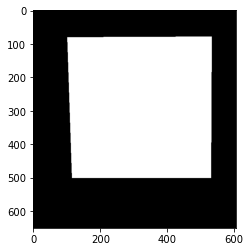

In [27]:
sample_mask = cv2.imread('../data/qsd2_w1/00000.png')
print (sample_mask.dtype, sample_mask.max())
plt.imshow(sample_mask)

In [ ]:
# Testing method 1

for image in qs2:
    f, axarr = plt.subplots(1,3, figsize=(10,10))
    base = image
    mask,coords = crop_image(otsus_binarization(rgb2gray(base)))
    cropped = base[coords[0]:coords[1],coords[2]:coords[3]]
    axarr[0].imshow(base)
    axarr[0].title.set_text("Base")
    axarr[1].imshow(mask,cmap="gray")
    axarr[1].title.set_text("Mask")
    axarr[2].imshow(cropped)
    axarr[2].title.set_text("Cropped")
    plt.show()

In [ ]:
# Testing Method 2

for image in qs2:
    f, axarr = plt.subplots(1,3, figsize=(10,10))
    base = image
    try:
        mask,coords = crop_image_2(rgb2gray(base))
        cropped = base[coords[0]:coords[1],coords[2]:coords[3]]
        axarr[0].imshow(base)
        axarr[0].title.set_text("Base")
        axarr[1].imshow(mask,cmap="gray")
        axarr[1].title.set_text("Mask")
        axarr[2].imshow(cropped)
        axarr[2].title.set_text("Cropped")
        plt.show()
    except Exception as err:
        print(err.args)

In [ ]:
# QUERYSET 2 
# Load Data
db, qs1, qs2 = load_data()

#new_qs2, masks = crop_images(qs2) Modify

# Feature extraction
db_feature_matrix = get_feature_matrix(dataset = db, n_bins = 16, desc = "Creating feature matrix for BBDD...(n_process = {})".format(n_process))
qs2_feature_matrix = get_feature_matrix(dataset = qs2, n_bins = 16, desc = "Creating feature matrix for QuerySet2...(n_process = {})".format(n_process))

# Similarity Computation
qs2_similarities = compute_similarities(qs = qs2_feature_matrix, desc = "Computing qs2 similarities...", similarity = 'correlation')

# Top K Estimation
top_k_qs2 = get_top_k(qs2_similarities, k = 1, desc = "Retrieving qs2 top K similar images...")

# Evaluation and Saving
predicted_results = save_results(top_k_qs1,"./week1/QST1/method1")
expected_results = pickle.load(open('../data/qsd1_w1/gt_corresps.pkl', "rb"))
metric = metrics.mapk(actual=expected_results,predicted=predicted_results,k=1)
print("MAP@K Score: {:.4f}% ({}/{})".format(metric*100,int(len(predicted_results)*metric),len(predicted_results)))

plot_image_and_similar()

In [8]:
## F1 SEGMENTATION

In [14]:
def iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def prec_recall (true_labels, pred_labels):
    
    true_labels = np.asarray(true_labels).astype(np.bool)
    pred_labels = np.asarray(pred_labels).astype(np.bool)
    
    # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
    TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

    precision = TP / (TP+FP)
    recall    = TP / (TP+FN)
    return precision, recall
    

def f1_dice(im1, im2):
    """
    Source: https://gist.github.com/JDWarner/6730747
    
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [15]:
!ls ../data/qsd2_w1/

00000.jpg  00005.png  00011.jpg  00016.png  00022.jpg  00027.png
00000.png  00006.jpg  00011.png  00017.jpg  00022.png  00028.jpg
00001.jpg  00006.png  00012.jpg  00017.png  00023.jpg  00028.png
00001.png  00007.jpg  00012.png  00018.jpg  00023.png  00029.jpg
00002.jpg  00007.png  00013.jpg  00018.png  00024.jpg  00029.png
00002.png  00008.jpg  00013.png  00019.jpg  00024.png  frames.pkl
00003.jpg  00008.png  00014.jpg  00019.png  00025.jpg  gt_corresps.pkl
00003.png  00009.jpg  00014.png  00020.jpg  00025.png
00004.jpg  00009.png  00015.jpg  00020.png  00026.jpg
00004.png  00010.jpg  00015.png  00021.jpg  00026.png
00005.jpg  00010.png  00016.jpg  00021.png  00027.jpg


In [16]:
imgs_q2  = sorted(glob("../data/qsd2_w1/*.jpg"))
masks_q2 = sorted(glob("../data/qsd2_w1/*.png"))

assert len(imgs_q2) == len(masks_q2)

print(f'QuerySet2 read: {len(imgs_q2)} images and {len(masks_q2)} masks')
print (imgs_q2[:3] , masks_q2[:3])

QuerySet2 read: 30 images and 30 masks
['../data/qsd2_w1/00000.jpg', '../data/qsd2_w1/00001.jpg', '../data/qsd2_w1/00002.jpg'] ['../data/qsd2_w1/00000.png', '../data/qsd2_w1/00001.png', '../data/qsd2_w1/00002.png']


Threshold found: 0.4695622870710784 (119.73838320312498 if not normalized)
Method 1 IOU 0.7335376743737028 - F1 0.8462898559602603 Prec 0.8393740886394768 Recall 0.853320530745863


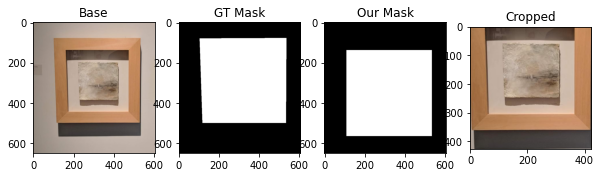

Threshold found: 0.4138076953125 (105.5209623046875 if not normalized)
Method 1 IOU 0.9891233909898285 - F1 0.994531958620848 Prec 0.9970791198798267 Recall 0.9919977782740396


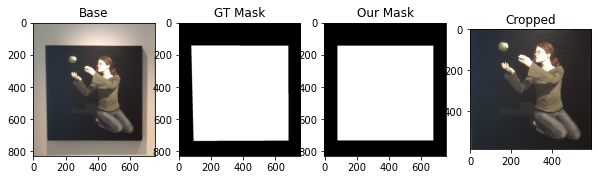

Threshold found: 0.40695364813112744 (103.7731802734375 if not normalized)
Method 1 IOU 0.6209234017644354 - F1 0.7661354029296352 Prec 0.8041709535928955 Recall 0.7315353591330316


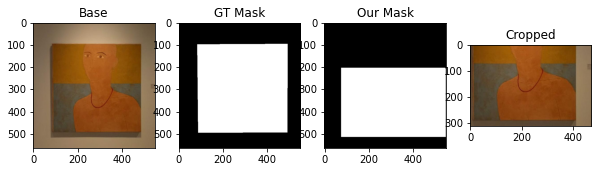

Threshold found: 0.4652679457720589 (118.64332617187502 if not normalized)
Method 1 IOU 0.9103224948767537 - F1 0.9530563528599227 Prec 0.9169117349826178 Recall 0.9921675515191943


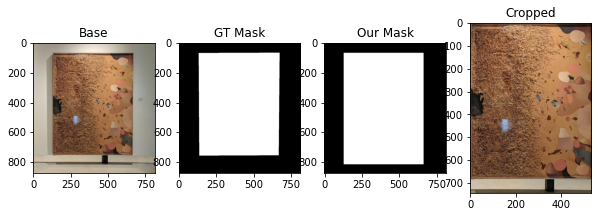

Threshold found: 0.5133392899816176 (130.9015189453125 if not normalized)
Method 1 IOU 0.856546643698444 - F1 0.9227310788078121 Prec 0.8881789137380192 Recall 0.9600803729808643


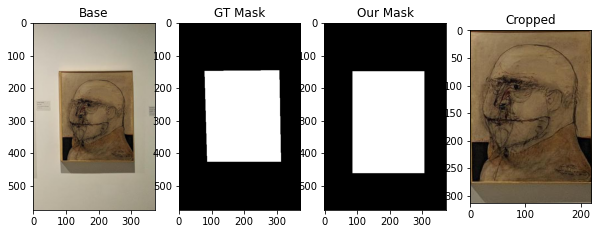

Threshold found: 0.453019387254902 (115.51994375000001 if not normalized)
Method 1 IOU 0.9716190763835579 - F1 0.9856052703301594 Prec 0.9943816221043051 Recall 0.9769824823066278


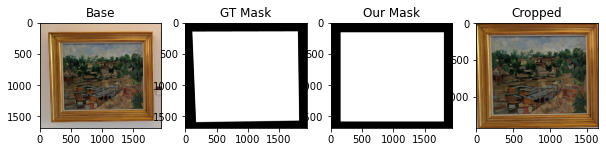

Threshold found: 0.3493252864583334 (89.07794804687501 if not normalized)
Method 1 IOU 0.9908774704893872 - F1 0.9954178347759542 Prec 0.9962036971456902 Recall 0.9946332112951479


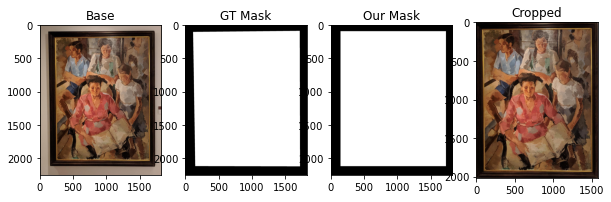

Threshold found: 0.4817813005514707 (122.85423164062503 if not normalized)
Method 1 IOU 0.7104605841018885 - F1 0.830724298128074 Prec 0.7104605841018885 Recall 1.0


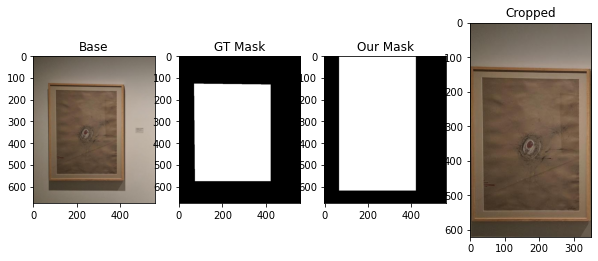

Threshold found: 0.5309784083946079 (135.399494140625 if not normalized)
Method 1 IOU 0.959208682641841 - F1 0.9791796975383168 Prec 0.9668642396154509 Recall 0.9918129401711081


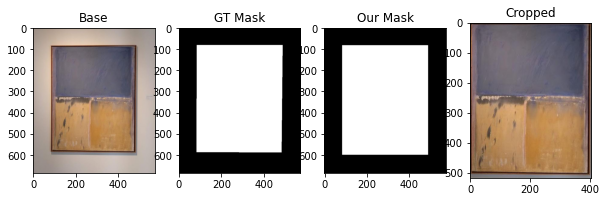

Threshold found: 0.4785819469975491 (122.03839648437501 if not normalized)
Method 1 IOU 0.6653873627371454 - F1 0.7990781936084213 Prec 0.666169696969697 Recall 0.998238157512351


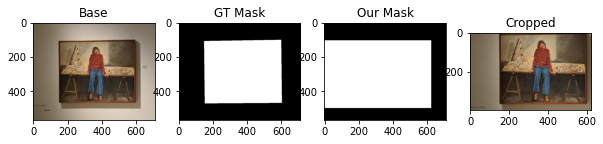

Threshold found: 0.35721975643382353 (91.091037890625 if not normalized)
Method 1 IOU 0.9806370177136365 - F1 0.9902238612561552 Prec 0.9910617850916358 Recall 0.9893873531209672


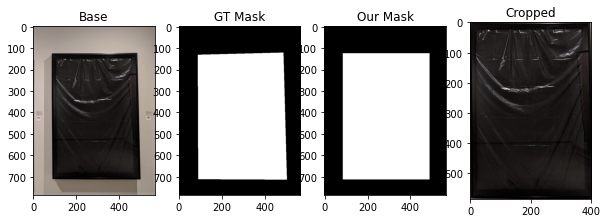

Threshold found: 0.6404610906862744 (163.31757812499998 if not normalized)
Method 1 IOU 0.975205647128644 - F1 0.9874472043417861 Prec 0.9957096886399827 Recall 0.9793207171331865


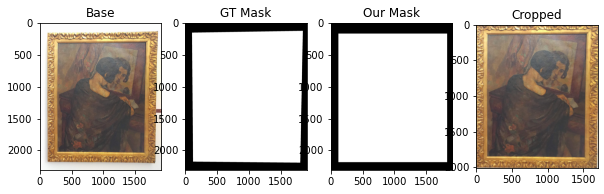

Threshold found: 0.39212640548406863 (99.9922333984375 if not normalized)
Method 1 IOU 0.9756913768741288 - F1 0.9876961435321282 Prec 0.9806324348765623 Recall 0.99486235338484


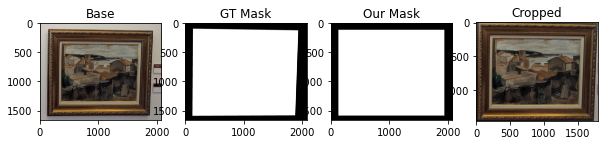

Threshold found: 0.4040682490808824 (103.03740351562502 if not normalized)
Method 1 IOU 0.9253870379979005 - F1 0.9612478112038786 Prec 0.9263461018128406 Recall 0.9988824545362186


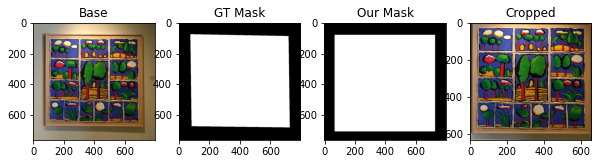

Threshold found: 0.44021321078431375 (112.25436875000001 if not normalized)
Method 1 IOU 0.8036996597283604 - F1 0.8911679451659914 Prec 0.8186108365108506 Recall 0.977838069599567


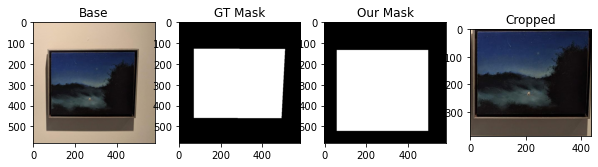

Threshold found: 0.4241061810661765 (108.147076171875 if not normalized)
Method 1 IOU 0.8054440013524993 - F1 0.8922392505656479 Prec 0.8101786844013764 Recall 0.9927966412163222


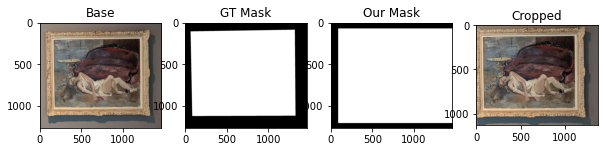

Threshold found: 0.3923704082414216 (100.05445410156251 if not normalized)
Method 1 IOU 0.9776143107482131 - F1 0.9886804574935962 Prec 0.998269904218558 Recall 0.9792734915649971


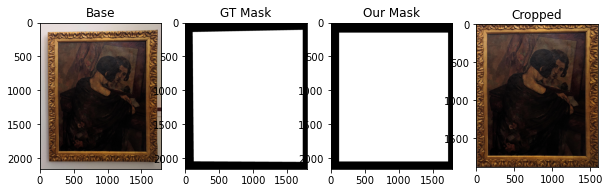

Threshold found: 0.41129372166053924 (104.8798990234375 if not normalized)
Method 1 IOU 0.8662859234719512 - F1 0.9283528451635678 Prec 0.9982710423159862 Recall 0.8675876222453353


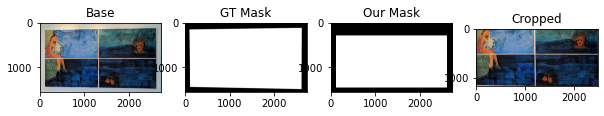

Threshold found: 0.39678324218750005 (101.17972675781252 if not normalized)
Method 1 IOU 0.913819302281409 - F1 0.9549692608827502 Prec 0.9330531986531987 Recall 0.97793964032636


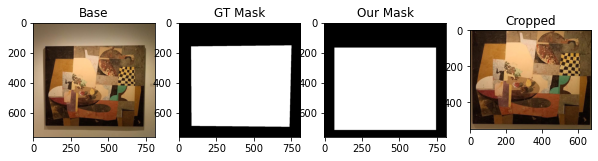

Threshold found: 0.458984375 (117.041015625 if not normalized)
Method 1 IOU 0.9570744742585552 - F1 0.9780664832605784 Prec 0.9654509734493059 Recall 0.9910160509315168


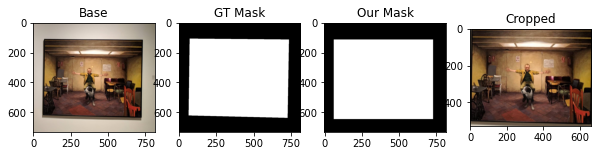

Threshold found: 0.4750083869485294 (121.127138671875 if not normalized)
Method 1 IOU 0.8100082340581738 - F1 0.8950326510306252 Prec 0.8167098816427689 Recall 0.9899712472734483


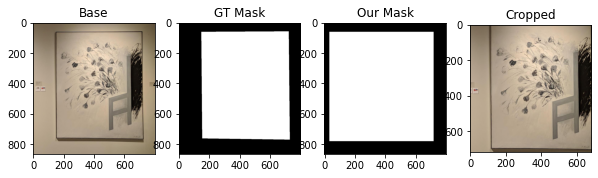

Threshold found: 0.5116649563419118 (130.4745638671875 if not normalized)
Method 1 IOU 0.9314977581378786 - F1 0.9645341333824984 Prec 0.9405025536261491 Recall 0.9898260189031365


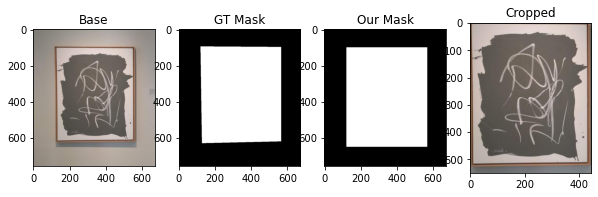

Threshold found: 0.40223924172794123 (102.57100664062501 if not normalized)
Method 1 IOU 0.8575079886443148 - F1 0.9232886145164405 Prec 0.8595344245304933 Recall 0.9972581794622611


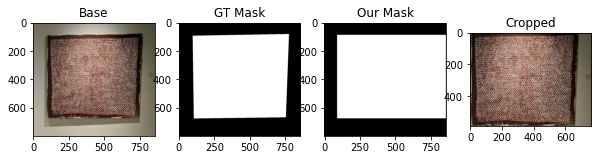

Threshold found: 0.40739520297181375 (103.88577675781251 if not normalized)
Method 1 IOU 0.9880065607992247 - F1 0.9939671028067665 Prec 0.9964104917701464 Recall 0.9915356678433491


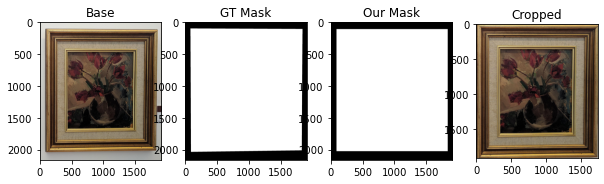

Threshold found: 0.3153539690563726 (80.415262109375 if not normalized)
Method 1 IOU 0.9410824566719673 - F1 0.9696470682502338 Prec 0.9481277354514508 Recall 0.992165920765823


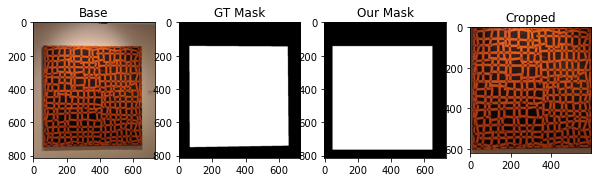

Threshold found: 0.3800858172487745 (96.9218833984375 if not normalized)
Method 1 IOU 0.9143936447975113 - F1 0.9552827834363483 Prec 0.9241825906309071 Recall 0.9885490070467648


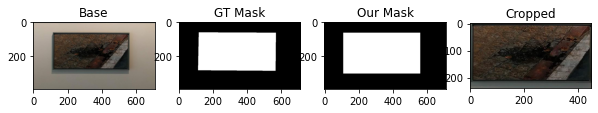

Threshold found: 0.5318330353860294 (135.6174240234375 if not normalized)
Method 1 IOU 0.9097118305059634 - F1 0.9527215739821251 Prec 0.9277738323688067 Recall 0.9790480746232959


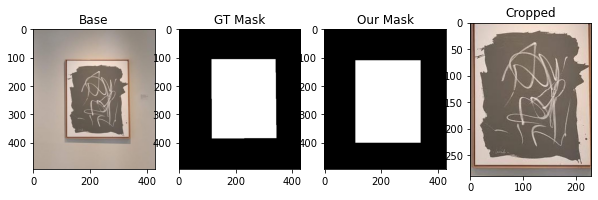

Threshold found: 0.3628692800245098 (92.53166640625 if not normalized)
Method 1 IOU 0.9799700630069272 - F1 0.9898837172504246 Prec 0.9904165493948776 Recall 0.9893514581122209


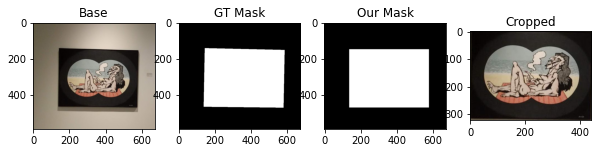

Threshold found: 0.4659076447610294 (118.8064494140625 if not normalized)
Method 1 IOU 0.5793612705651523 - F1 0.7336652878132639 Prec 0.7895879857482528 Recall 0.6851401265497326


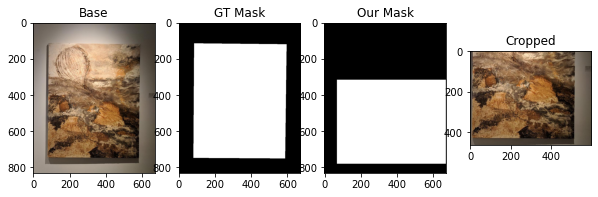

Threshold found: 0.49692729319852946 (126.71645976562502 if not normalized)
Method 1 IOU 0.6505657063730622 - F1 0.7882942240483225 Prec 0.6761179361179361 Recall 0.945097538956706


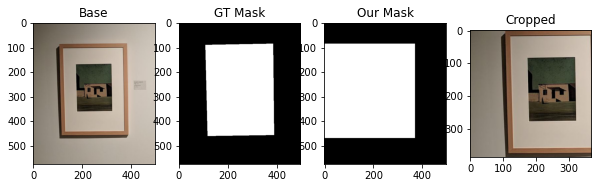

[0.87169903 0.92663861 0.90222478 0.9595872 ]


In [17]:
# Testing method 1

SCORES = []
METHOD = 1

for i,m in zip(imgs_q2, masks_q2):
    
    base    = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
    gt_mask = cv2.imread(m , cv2.IMREAD_GRAYSCALE)
    
    assert base.shape[0] == gt_mask.shape[0]
    assert base.shape[1] == gt_mask.shape[1]
    
    if METHOD == 1:
        mask,coords = crop_image(otsus_binarization(rgb2gray(base)))
        cropped     = base[coords[0]:coords[1],coords[2]:coords[3]]
        
        f1  = f1_dice(gt_mask, mask)
        iou = iou_score(gt_mask, mask)
        prec , recall = prec_recall(gt_mask, mask)
    
    else:
        try:
            mask2,coords2 = crop_image_2(rgb2gray(base))
            cropped2      = base[coords2[0]:coords2[1],coords2[2]:coords2[3]]
            
            f1_2  = f1_dice(gt_mask, mask2)
            iou_2 = iou_score(gt_mask, mask2)
            prec2 , recall2 = prec_recall(gt_mask, mask2)

        except Exception as err:
            print(err.args)
    
    if METHOD == 1:
        print (f'Method 1 IOU {iou} - F1 {f1} Prec {prec} Recall {recall}')
        SCORES.append((iou, f1, prec, recall))
    else:
        print (f'Method 2 IOU {iou_2} - F1 {f1_2} Prec {prec2} Recall {recall2}')
        SCORES.append((iou_2, f1_2, prec2, recall2))
    
    
    if METHOD != 1:
        mask = mask2
        cropped = cropped2
        
    f, axarr = plt.subplots(1,4, figsize=(10,10))
    axarr[0].imshow(base)
    axarr[0].title.set_text("Base")
    axarr[1].imshow(gt_mask,cmap="gray")
    axarr[1].title.set_text("GT Mask")
    axarr[2].imshow(mask,cmap="gray")
    axarr[2].title.set_text("Our Mask")
    axarr[3].imshow(cropped)
    axarr[3].title.set_text("Cropped")
    plt.show()
    
    del mask, base, gt_mask
    
    
print (np.mean(SCORES, axis=0))

In [46]:
!mkdir method1/ method2/

mkdir: cannot create directory ‘method1/’: File exists
mkdir: cannot create directory ‘method2/’: File exists


In [47]:
!rm method1/* method2/*

In [48]:
!ls ../data/qst2_w1

00000.jpg  00005.jpg  00010.jpg  00015.jpg  00020.jpg  00025.jpg
00001.jpg  00006.jpg  00011.jpg  00016.jpg  00021.jpg  00026.jpg
00002.jpg  00007.jpg  00012.jpg  00017.jpg  00022.jpg  00027.jpg
00003.jpg  00008.jpg  00013.jpg  00018.jpg  00023.jpg  00028.jpg
00004.jpg  00009.jpg  00014.jpg  00019.jpg  00024.jpg  00029.jpg


In [49]:
test  = sorted(glob("../data/qst2_w1/*.jpg"))
print (len(test) , test[:2])

30 ['../data/qst2_w1/00000.jpg', '../data/qst2_w1/00001.jpg']


Threshold found: 0.5318214169730393 (135.61446132812503 if not normalized)
../data/qst2_w1/00000.jpg (501, 394, 3)


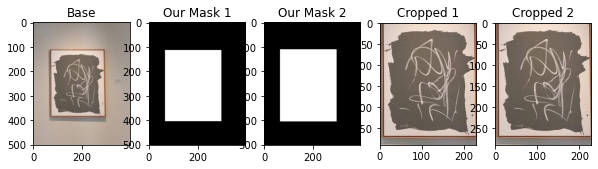

Threshold found: 0.40055061504289213 (102.1404068359375 if not normalized)
../data/qst2_w1/00001.jpg (691, 681, 3)


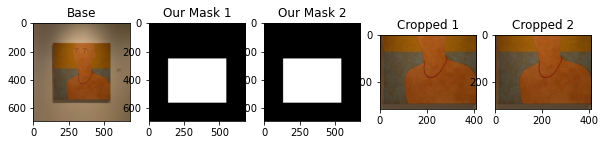

Threshold found: 0.4306754082414216 (109.8222291015625 if not normalized)
../data/qst2_w1/00002.jpg (509, 485, 3)


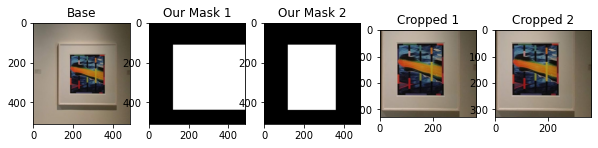

Threshold found: 0.598911153492647 (152.72234414062498 if not normalized)
../data/qst2_w1/00003.jpg (863, 703, 3)


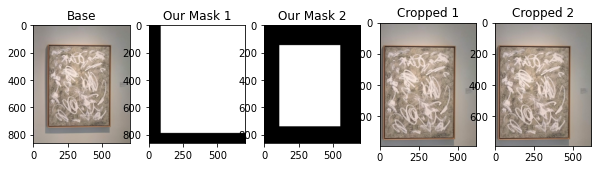

Threshold found: 0.49436943474264705 (126.064205859375 if not normalized)
../data/qst2_w1/00004.jpg (457, 359, 3)


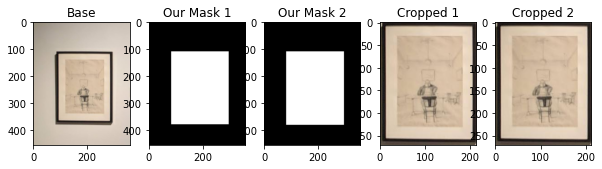

Threshold found: 0.38288157858455885 (97.6348025390625 if not normalized)
../data/qst2_w1/00005.jpg (1482, 1192, 3)


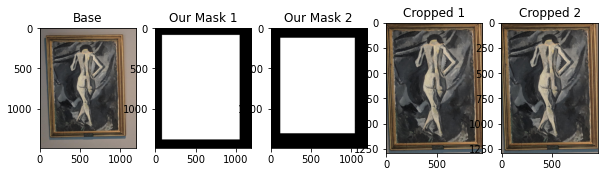

Threshold found: 0.4833474946384805 (123.25361113281252 if not normalized)
../data/qst2_w1/00006.jpg (741, 592, 3)


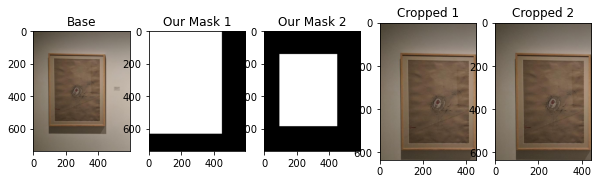

Threshold found: 0.3665702872242647 (93.4754232421875 if not normalized)
../data/qst2_w1/00007.jpg (541, 612, 3)


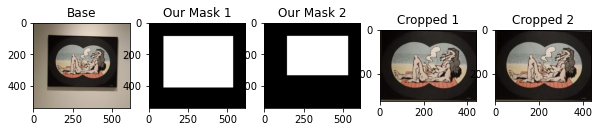

Threshold found: 0.5527633785232844 (140.95466152343752 if not normalized)
../data/qst2_w1/00008.jpg (807, 615, 3)


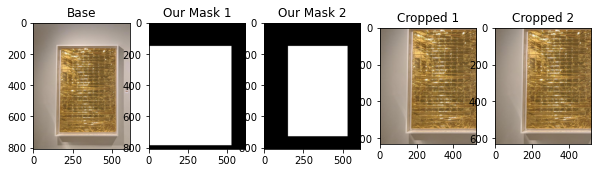

Threshold found: 0.3851411557904412 (98.21099472656252 if not normalized)
../data/qst2_w1/00009.jpg (1668, 2014, 3)


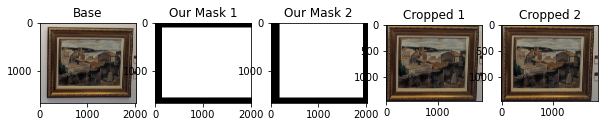

Threshold found: 0.406015964307598 (103.53407089843749 if not normalized)
../data/qst2_w1/00010.jpg (813, 755, 3)


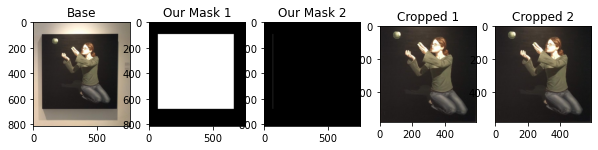

Threshold found: 0.3893532536764706 (99.2850796875 if not normalized)
../data/qst2_w1/00011.jpg (2111, 1807, 3)


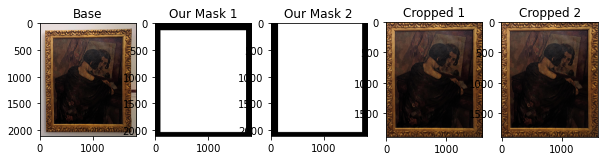

Threshold found: 0.393520787377451 (100.34780078125 if not normalized)
../data/qst2_w1/00012.jpg (786, 823, 3)


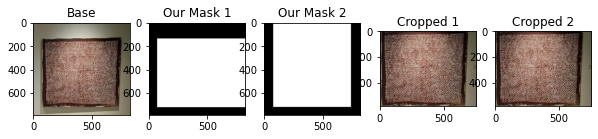

Threshold found: 0.38519024280024505 (98.22351191406248 if not normalized)
../data/qst2_w1/00013.jpg (1336, 1101, 3)


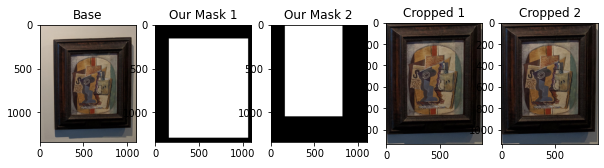

Threshold found: 0.537225487132353 (136.99249921875 if not normalized)
../data/qst2_w1/00014.jpg (786, 573, 3)


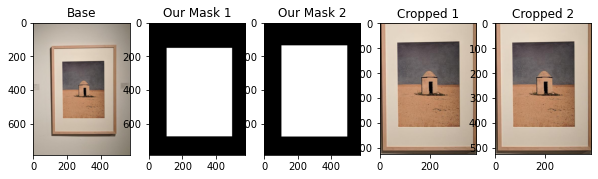

Threshold found: 0.3469404159007353 (88.46980605468751 if not normalized)
../data/qst2_w1/00015.jpg (2184, 1820, 3)


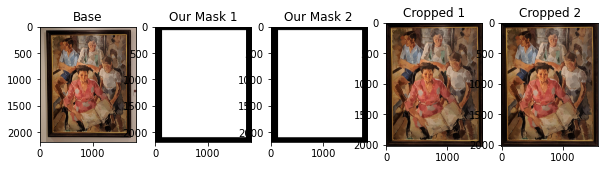

Threshold found: 0.5005970404411765 (127.6522453125 if not normalized)
../data/qst2_w1/00016.jpg (1524, 1293, 3)


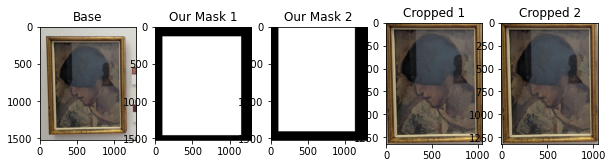

Threshold found: 0.6364301248468138 (162.28968183593753 if not normalized)
../data/qst2_w1/00017.jpg (2310, 1875, 3)


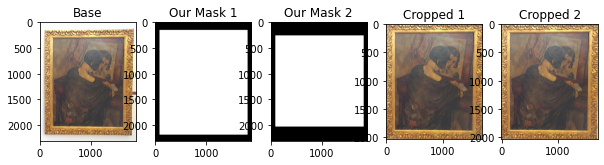

Threshold found: 0.46630250995710787 (118.90714003906251 if not normalized)
../data/qst2_w1/00018.jpg (537, 657, 3)


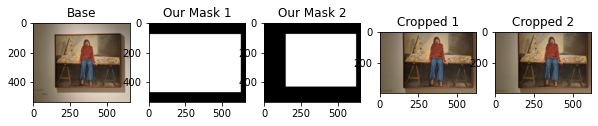

Threshold found: 0.41117719975490197 (104.8501859375 if not normalized)
../data/qst2_w1/00019.jpg (1544, 2744, 3)


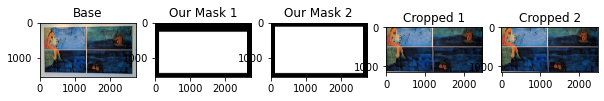

Threshold found: 0.4981376156556373 (127.02509199218751 if not normalized)
../data/qst2_w1/00020.jpg (552, 532, 3)


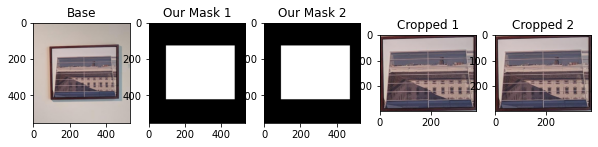

Threshold found: 0.4313965364583334 (110.00611679687502 if not normalized)
../data/qst2_w1/00021.jpg (1591, 1853, 3)


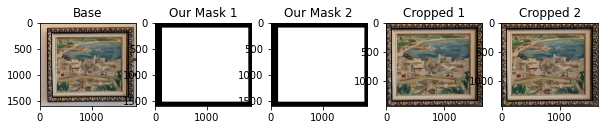

Threshold found: 0.4664652642463235 (118.9486423828125 if not normalized)
../data/qst2_w1/00022.jpg (867, 771, 3)


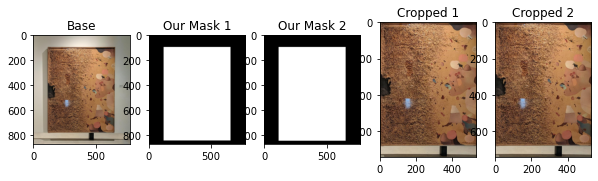

Threshold found: 0.4277720350796569 (109.08186894531251 if not normalized)
../data/qst2_w1/00023.jpg (859, 957, 3)


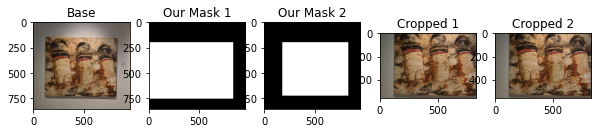

Threshold found: 0.44093853630514707 (112.4393267578125 if not normalized)
../data/qst2_w1/00024.jpg (2172, 2136, 3)


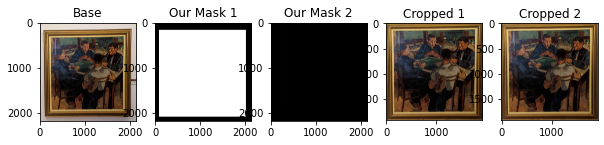

Threshold found: 0.5071504227941177 (129.3233578125 if not normalized)
../data/qst2_w1/00025.jpg (563, 421, 3)


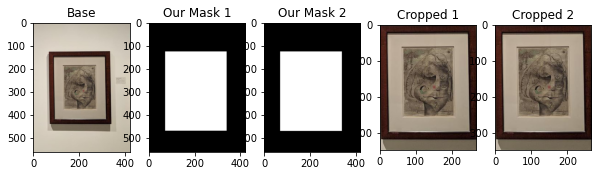

Threshold found: 0.4895523628982843 (124.8358525390625 if not normalized)
../data/qst2_w1/00026.jpg (640, 816, 3)


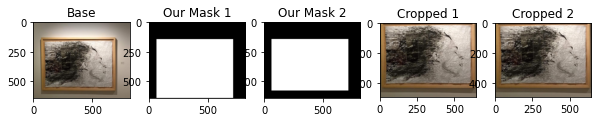

Threshold found: 0.42536546415441184 (108.46819335937502 if not normalized)
../data/qst2_w1/00027.jpg (500, 643, 3)


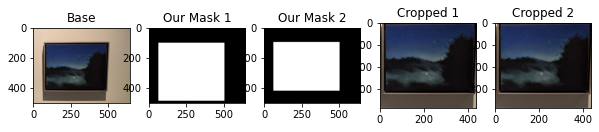

Threshold found: 0.474017896752451 (120.874563671875 if not normalized)
../data/qst2_w1/00028.jpg (422, 555, 3)


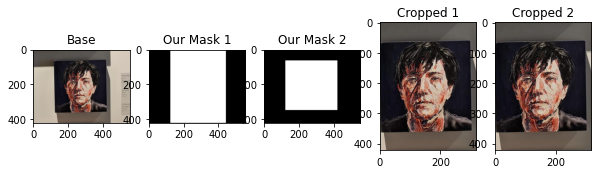

Threshold found: 0.47164695542279417 (120.26997363281251 if not normalized)
../data/qst2_w1/00029.jpg (893, 772, 3)


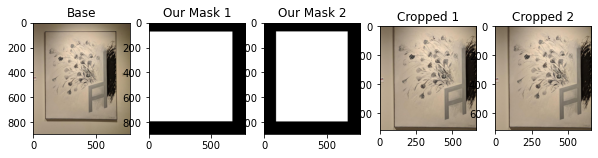

In [50]:
# TESTING - GENERATING SUBMISSION

SOLUTION = {}

for file in test:
    
    base    = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)

    mask,coords = crop_image(otsus_binarization(rgb2gray(base)))
    cropped     = base[coords[0]:coords[1],coords[2]:coords[3]]
    
    print (file, base.shape)

    try:
        mask2,coords2 = crop_image_2(rgb2gray(base))
        cropped2      = base[coords2[0]:coords2[1],coords2[2]:coords2[3]]
            
    except Exception as err:
        #print(err.args)
        mask2,coords2 = mask, coords
        cropped2 = cropped
        
    mask2 = mask2.astype(np.uint8) * 255
    mask  = mask.astype(np.uint8) * 255
    
    ID = file.replace('../data/qst2_w1/','').replace('.jpg', '')

    cv2.imwrite (f'method1/{ID}.png', mask)
    cv2.imwrite (f'method2/{ID}.png', mask2)
    
    f, axarr = plt.subplots(1,5, figsize=(10,10))
    axarr[0].imshow(base)
    axarr[0].title.set_text("Base")
    axarr[1].imshow(mask,cmap="gray")
    axarr[1].title.set_text("Our Mask 1")
    axarr[2].imshow(mask2,cmap="gray")
    axarr[2].title.set_text("Our Mask 2")
    axarr[3].imshow(cropped)
    axarr[3].title.set_text("Cropped 1")
    axarr[4].imshow(cropped)
    axarr[4].title.set_text("Cropped 2")
    plt.show()
    
    ID = int(file.replace('../data/qst2_w1/','').replace('.jpg', ''))
    SOLUTION[ID] = (file , mask , mask2)


In [51]:
output = open('solution_qst2.pkl', 'wb')
pickle.dump(SOLUTION, output)
output.close()

In [52]:
!ls method1

00000.png  00005.png  00010.png  00015.png  00020.png  00025.png
00001.png  00006.png  00011.png  00016.png  00021.png  00026.png
00002.png  00007.png  00012.png  00017.png  00022.png  00027.png
00003.png  00008.png  00013.png  00018.png  00023.png  00028.png
00004.png  00009.png  00014.png  00019.png  00024.png  00029.png


In [53]:
!ls method2

00000.png  00005.png  00010.png  00015.png  00020.png  00025.png
00001.png  00006.png  00011.png  00016.png  00021.png  00026.png
00002.png  00007.png  00012.png  00017.png  00022.png  00027.png
00003.png  00008.png  00013.png  00018.png  00023.png  00028.png
00004.png  00009.png  00014.png  00019.png  00024.png  00029.png


uint8 255


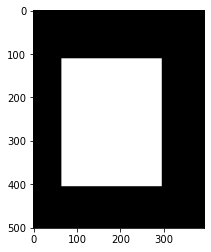

In [55]:
sample_mask = cv2.imread('method2/00000.png')
print (sample_mask.dtype, sample_mask.max())
plt.imshow(sample_mask)

In [58]:
!du -sh method1 method2

224K	method1
236K	method2
